### Nonlinear robust MPC

This notebook showcases the usage of [nonlinear tube-MPC](../ampyc/controllers/nonlinear_robust_mpc.py) [1] with ellipsoidal tubes. The accompanying notes for this notebook are [here](../notes/03_robustNMPC1.pdf) and [here](../notes/04_robustNMPC2.pdf).

[1] F. Bayer, M. Bürger, and F. Allgöwer, "Discrete-time incremental ISS: A framework for robust NMPC", European Control Conference (ECC), 2013.

In [1]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import the default parameters, the nonlinear system, and the nonlinear tube-MPC controller
from ampyc.params import NonlinearRMPCParams
from ampyc.systems import NonlinearSystem
from ampyc.controllers import NonlinearRMPC

# import additional utilities from ampyc (plotting and RoA computation)
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_tubes
from ampyc.utils import Polytope, compute_RoA

First, we instantiate the nonlinear system and the nonlinear tube-MPC using the loaded default parameters.

Note: The system we are using here has a state dependent disturbance, i.e., the disturbance acting on the system might be smaller than in previous examples.

In [2]:
params = NonlinearRMPCParams()
sys = NonlinearSystem(params.sys)
ctrl = NonlinearRMPC(sys, params.ctrl)

Successfully initialized experiment 'robust nonlinear MPC'.


Next, we compute and plot the ellipsoidal tube that is used in nonlinear tube-MPC. The size of the tube is governed by the contraction rate rho. You can try various values for rho and observe the produced plots.

Note: Choose a value for rho making sure the resulting RPI set is contained in the state constraints

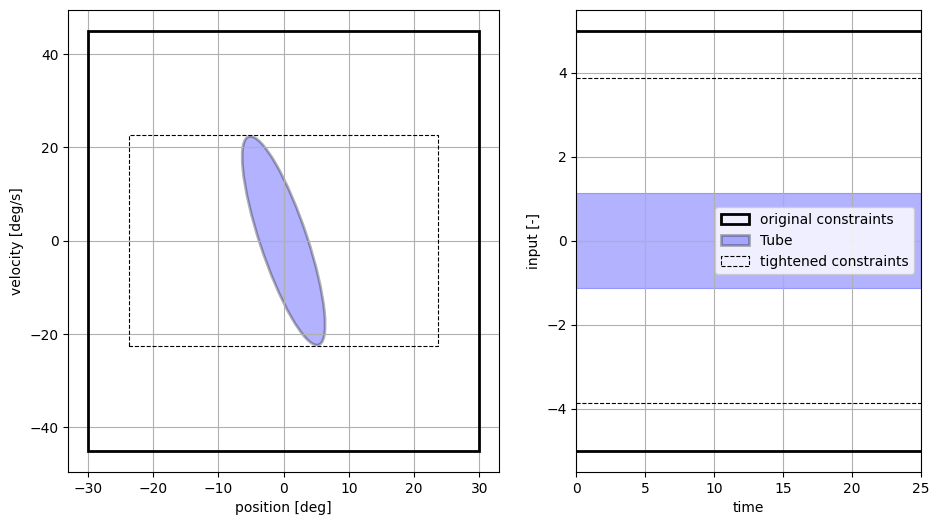

In [3]:
rho = 0.75
_, _, F, K, delta, w_bar = ctrl.compute_tightening(rho)

# convert state sets to degrees for plotting
X_deg = (180/np.pi * sys.X)
conversion_factor = (np.pi/180)**2
F_deg = conversion_factor/delta**2 * F # also normalize by delta

# undo conversion for input
K_deg = np.sqrt(conversion_factor)*K

# plot
plot_tubes(1, F_deg, K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

After choosing a suitable rho, we re-initialize nonlinear tube-MPC and simulate it in closed-loop with the nonlinear system

In [4]:
# NOTE: running this cell might take a while

# re-initialize the controller with the chosen rho
ctrl = NonlinearRMPC(sys, params.ctrl, rho)

# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_v, sol_z, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)

        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # compute the control law
        pi = sol_v[0] + ctrl.K @ (x[j,:,i] - sol_z[:,0])

        # advance the system
        u[j,i] = pi.item() # need .item(), since u is a scalar
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

Then, we can plot the closed-loop trajectories. We do this in angular coordinates, since the system we are simulating is a simplified segway model.

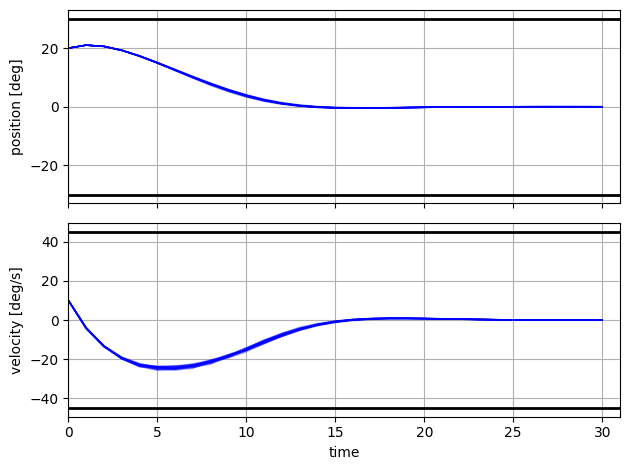

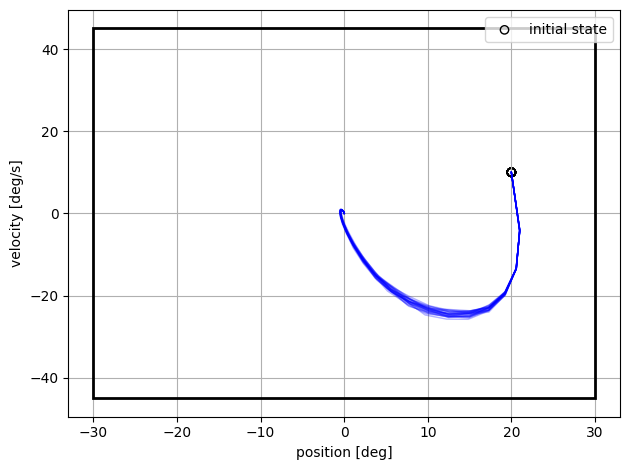

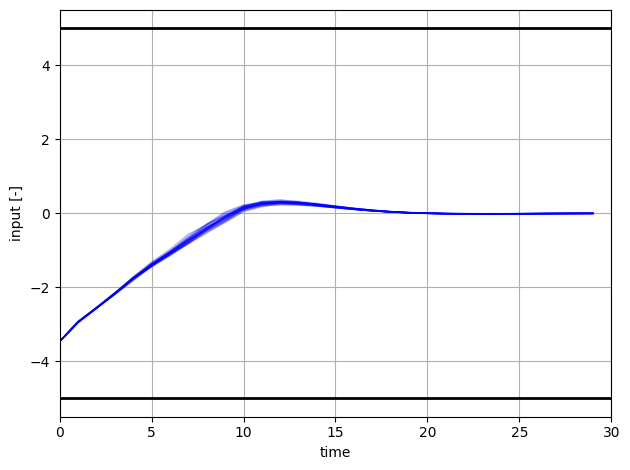

In [5]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot the closed-loop state and input trajectories
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

Finally, we compute the region of attraction (RoA), i.e., the set of initial states for which the nonlinear tube-MPC is feasible.

Note: Since computing the RoA will include solving the MPC for initial states close to infeasibility, you might encounter solver warnings regarding numerical inaccuracies. Here, these warnings can be safely ignored.

100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


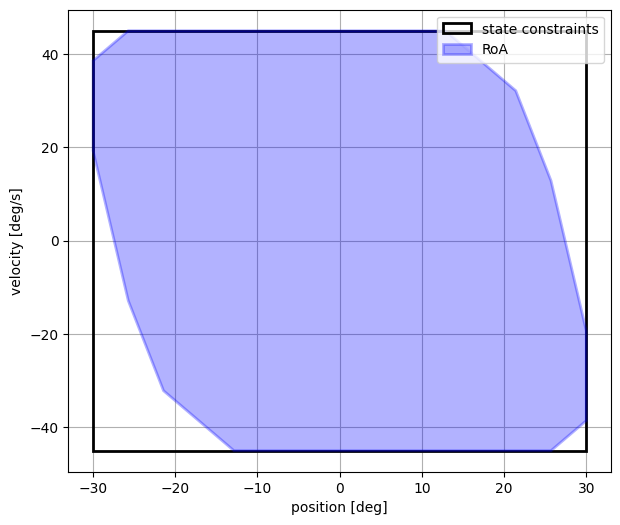

In [6]:
# NOTE: running this cell might take a while
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA
RoA = compute_RoA(ctrl, sys, grid_size=15)

# convert state constraints and RoA to degrees for plotting
X_deg = (180/np.pi) * sys.X
RoA = (180/np.pi) * RoA

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc='upper right')
plt.show()

#### Disturbance Avoidance
The nonlinear tube-MPC also implements a disturbance avoidance constraint, which is useful if the disturbance acting on the system is state dependent (as is the case here). Next, we see how this works by defining `w_hat`, which quantifies the disturbance level that should be avoided. `w_hat` should be a fraction of the previously computed `w_bar` above.

Note: If you choose `w_hat` too small you will run into feasibility issues, but feel free to play around with it (and also `rho` above).

In [7]:
# choose w_hat and re-initialize the controller
w_hat = w_bar * 0.55
ctrl = NonlinearRMPC(sys, params.ctrl, rho, w_hat)

# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories
xx = np.zeros((num_steps+1, sys.n, num_traj))
uu = np.zeros((num_steps, num_traj))
xx[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_v, sol_z, error_msg = ctrl.solve(xx[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # compute the control law
        pi = sol_v[0] + ctrl.K @ (xx[j,:,i] - sol_z[:,0])

        # advance the system
        uu[j,i] = pi.item() # need .item(), since u is a scalar
        xx[j+1,:,i] = sys.get_state(xx[j,:,i], uu[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

Then, we can plot the new closed-loop trajectories together with the previous ones to compare them and visualize how large uncertainties are avoided. We again plot in angular coordinates.

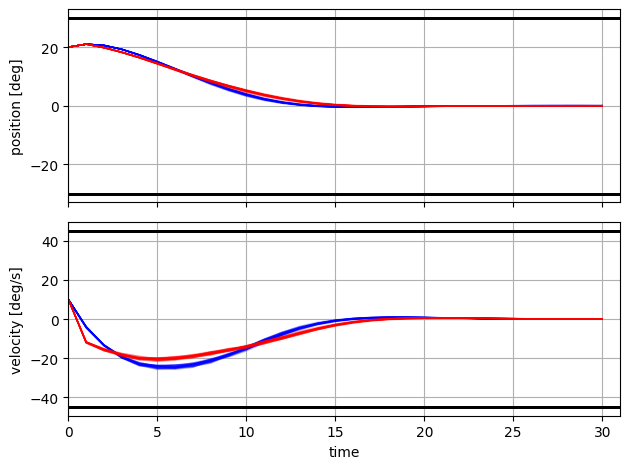

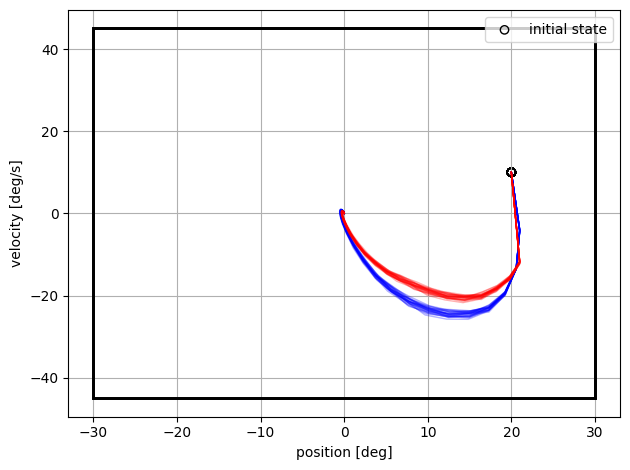

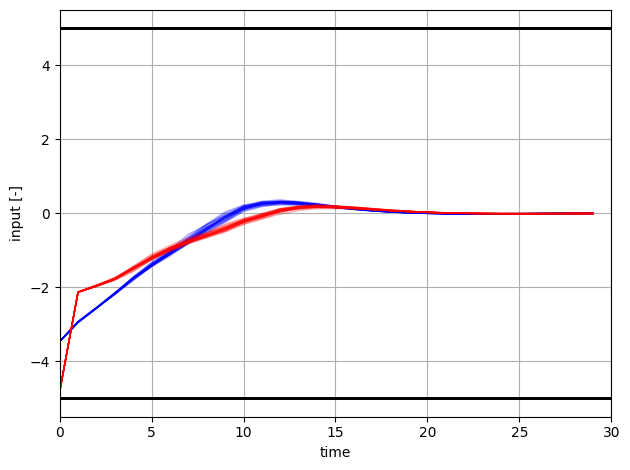

In [8]:
# convert the new state trajectory to degrees for plotting
xx_deg = np.rad2deg(xx)

# plot the previous trajectories
params.plot.color = 'blue' # ensure the previous trajectories are plotted in blue
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

# plot the new closed-loop trajectories and highlight them in red
params.plot.color = 'red'
plot_x_state_time(1, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, uu, sys.U, params.plot, axes_labels=['input [-]'])

Note how the trajectories using the disturbance avoidance constraint avoid large velocities (2nd state; best visible in the state-state plot). This is due to the state dependent noise only acting on the second state.

The same behavior is also apparent when comparing the RoAs of nonlinear tube-MPC with and without the disturbance avoidance constraint, since initial states with large velocities (2nd state) will not be feasible with the avoidance constraint.

100%|██████████| 15/15 [08:01<00:00, 32.10s/it]


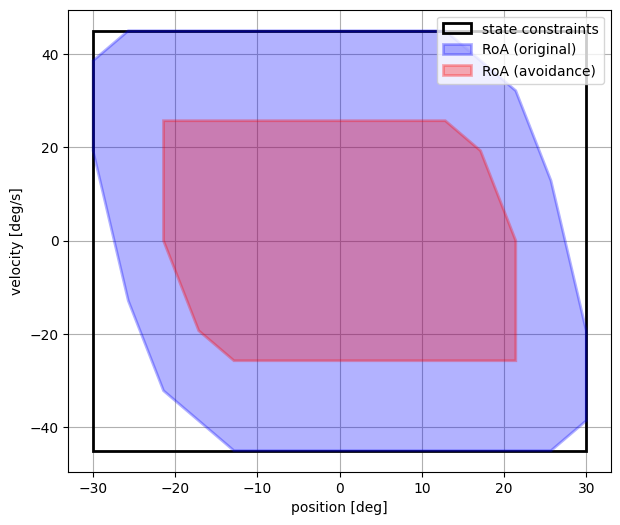

In [9]:
# WARNING: running this cell takes several minutes!
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA
RoA_avoidance = compute_RoA(ctrl, sys, grid_size=15)

# convert state constraints and RoA to degrees for plotting
X_deg = (180/np.pi) * sys.X
RoA_avoidance = (180/np.pi) * RoA_avoidance

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA (original)')
RoA_avoidance.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=2, label='RoA (avoidance)')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc='upper right')
plt.show()